Doesn't work on sim_008!

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

# Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import clip_windows
import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("./simulations/sim_008_lc.dat",sep=' ', header = None, names=['Time', 'LC', 'N'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
LC      float64
N       float64
dtype: object

In [5]:
X, Y, N = df['Time'].tolist(), df['LC'].tolist(), df['N'].tolist()
X, Y, N = np.array(X), np.array(Y), np.array(N)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

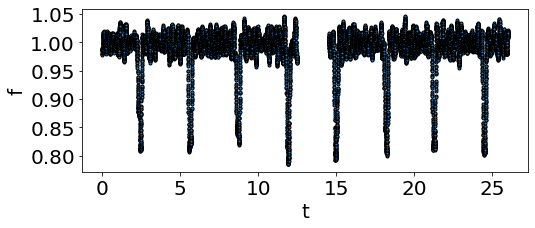

In [6]:
plotter.plot_data(X, Y)

array([0.        , 0.31540146, 0.32309418, 0.63849565, 0.63080293])

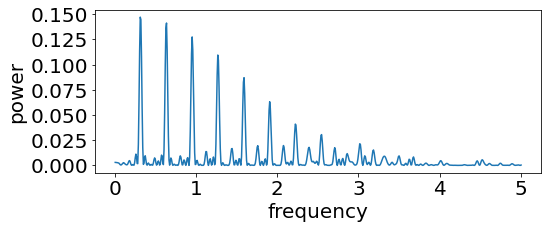

In [7]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [8]:
# For sim_008, 9000 is the first large envelope
N_part=9000

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

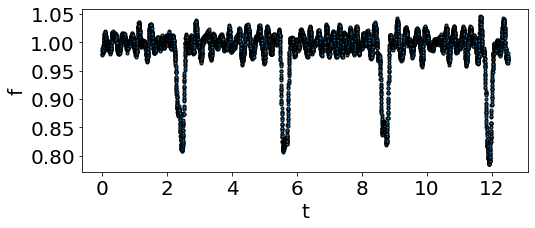

In [10]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
# normalize the data
# _, _, Y_part = experiment_util.normalize_mean(Y_part)

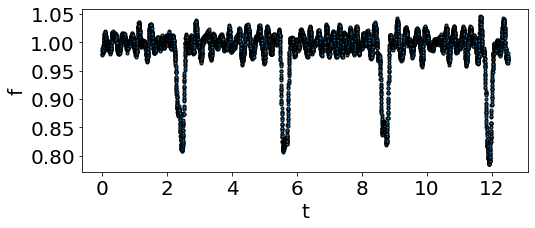

In [12]:
plotter.plot_data(X_part, Y_part)

In [13]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+3917) * sample_period
first_sec_eclipse_date = X_part[0] + (+1590) * sample_period

# Take the frequency with the highest amplitude from the periodogram!!
eclipse_period = 2 * (1/0.31540146)

window_size = 260  # todo: window size in duration
eclipse_duration = window_size * sample_period
X_part_window, Y_part_window = clip_windows.clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

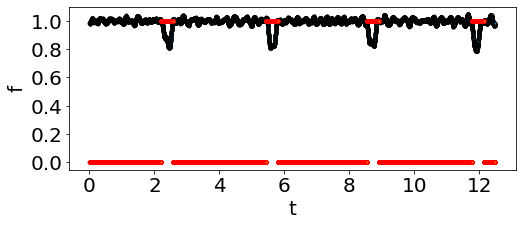

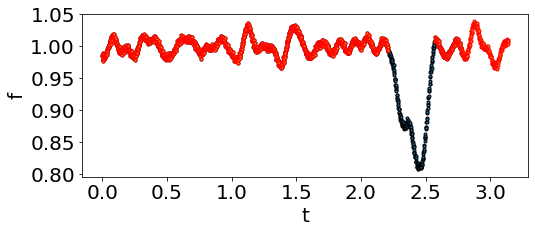

In [14]:
# Plot the masks and the remaining observations after removing the eclipses
X_without_gaps, Y_mask, Y_without_gaps = clip_windows.prepare_masks(X_part, Y_part, X_part_window)

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part[:2000], Y_part[:2000], X_without_gaps[:2000], Y_without_gaps[:2000])
#plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

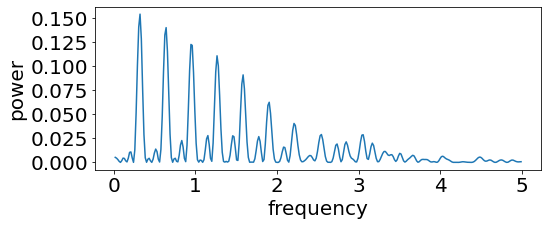

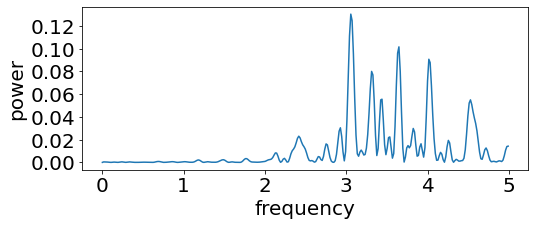

In [15]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

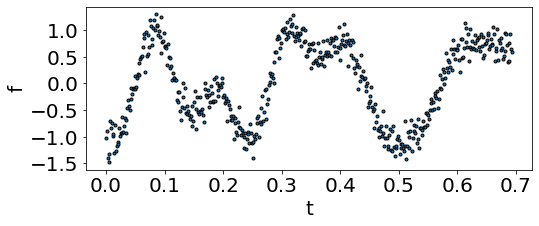

In [16]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
_, _, Y_part = experiment_util.normalize_mean(Y_part)
plotter.plot_data(X_part_window[:500], Y_part_window[:500])

Move data and models to the GPU

array([3.05633959, 3.07234137, 3.04033782, 3.64840538, 3.6324036 ])

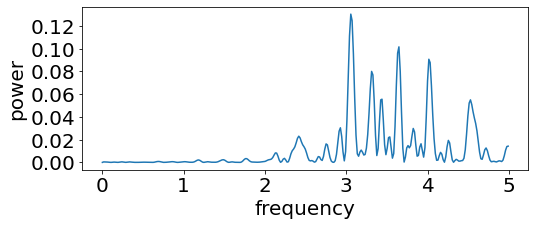

In [17]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [18]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)
X_part_window=torch.tensor(X_part_window)
Y_part_window=torch.tensor(Y_part_window)

if USE_CUDA:
    X_part = X_part.cuda()
    Y_part = Y_part.cuda()
    X_part_window = X_part_window.cuda()
    Y_part_window = Y_part_window.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [19]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # Periodic kernel 1
        sho1 = gpytorch.kernels.PeriodicKernel()
        sho1.period_length = 1/3.06242097
        sho1.lengthscale = 0.001
        # Periodic kernel 2
        sho2 = gpytorch.kernels.PeriodicKernel()
        sho2.period_length = 1/4.02253133
        sho2.lengthscale = 0.001
        # RBF kernel for the uncorrelated noise
        self.noise_kernel = gpytorch.kernels.RBFKernel()

        self.covar_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(sho1),
            gpytorch.kernels.ScaleKernel(sho2),
            gpytorch.kernels.ScaleKernel(self.noise_kernel),
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part_window, Y_part_window, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [20]:
training_iter = 50

# NOTE: you can not run this with 100 iterations as it will have large spikes
# in the gaps due to the length scale becoming very large
# TODO: should we set a prior on the length scale, with minimum length?

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part_window)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part_window)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.390
Iter 2/50 - Loss: 1.482
Iter 3/50 - Loss: 1.476
Iter 4/50 - Loss: 1.465
Iter 5/50 - Loss: 1.414
Iter 6/50 - Loss: 1.444
Iter 7/50 - Loss: 1.424
Iter 8/50 - Loss: 1.426
Iter 9/50 - Loss: 1.443
Iter 10/50 - Loss: 1.401
Iter 11/50 - Loss: 1.417
Iter 12/50 - Loss: 1.433
Iter 13/50 - Loss: 1.424
Iter 14/50 - Loss: 1.418
Iter 15/50 - Loss: 1.413
Iter 16/50 - Loss: 1.396
Iter 17/50 - Loss: 1.416
Iter 18/50 - Loss: 1.409
Iter 19/50 - Loss: 1.419
Iter 20/50 - Loss: 1.409
Iter 21/50 - Loss: 1.398
Iter 22/50 - Loss: 1.422
Iter 23/50 - Loss: 1.423
Iter 24/50 - Loss: 1.421
Iter 25/50 - Loss: 1.421
Iter 26/50 - Loss: 1.417
Iter 27/50 - Loss: 1.418
Iter 28/50 - Loss: 1.419
Iter 29/50 - Loss: 1.419
Iter 30/50 - Loss: 1.414
Iter 31/50 - Loss: 1.409
Iter 32/50 - Loss: 1.411
Iter 33/50 - Loss: 1.409
Iter 34/50 - Loss: 1.405
Iter 35/50 - Loss: 1.407
Iter 36/50 - Loss: 1.407
Iter 37/50 - Loss: 1.410
Iter 38/50 - Loss: 1.409
Iter 39/50 - Loss: 1.405
Iter 40/50 - Loss: 1.403
Iter 41/5

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

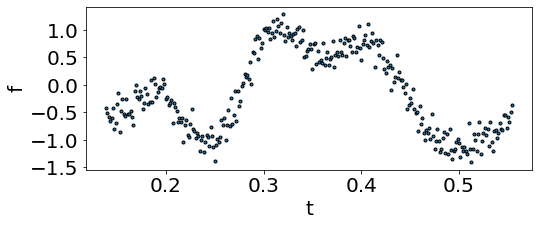

In [22]:
plotter.plot_series(X_part_window.cpu().numpy()[100:400], Y_part_window.cpu().numpy()[100:400])

In [23]:
# Predict on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred_norm = likelihood(model(X_part))
Y_part_pred_norm = Y_part_pred_norm.mean.cpu().numpy()

In [25]:
Y_part_pred = (Y_part_pred_norm * std) + mean

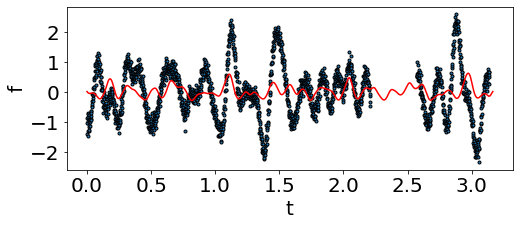

In [26]:
plotter.plot_series(X_part_window[:2000], Y_part_window[:2000], X_part[:2280], Y_part_pred_norm[:2280])
# plotter.plot_series(X_part_window, Y_part_window, X_part, Y_part_pred_norm)

array([0.        , 2.16024003, 2.14423825, 2.1762418 , 2.12823647])

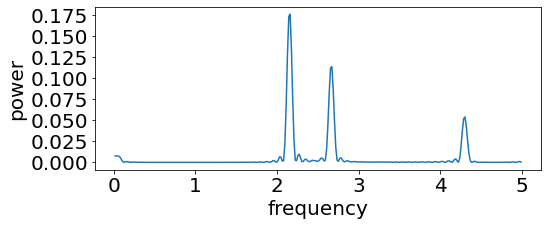

In [27]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part_pred_norm, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

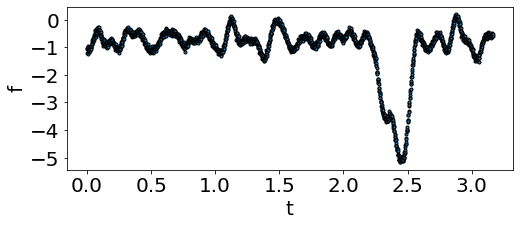

In [28]:
plotter.plot_series(X_part[:2280], (Y_part - Y_part_pred)[:2280])

array([0.        , 0.32003556, 0.30403378, 0.64007112, 0.62406934])

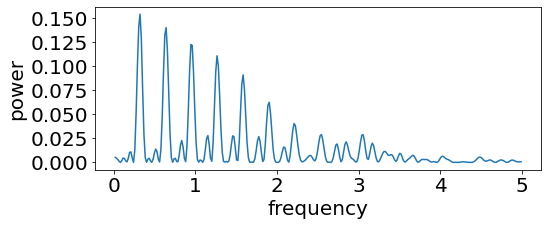

In [29]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part - Y_part_pred, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]